# Big Data Collection

In this file, I take the data that is too large to be presented in the main file. It will be processed here, and the results will be presented.

In [3]:
import pylab as plt
import numpy as np
import random
%matplotlib inline

In [4]:
def friction (vi, vf, F0):
    """
    Returns the friction of the bottom plate against blocks moving at a specific velocity
    
    Arguments:  vi - initial velocity of the block
                vf - final velocity of the block
                F0 - the static friction force
    
    Returned: The force due to friction
    
    Examples:
    
    >>> friction (0, 1, 20)
    -20.0
    
    >>> friction (1, 1, 20)
    -10.0
    """
    # Calculates sign of vi
    if vi == 0:
        sign = 1
        
    else:
        sign = vi / abs(vi)
        
    force = -((F0) * sign / (1 + abs(vi/vf)))
    return force

In [5]:
def blockMotion (t, blockPositions, vBlock, i, blockNum, kp, kc, mass, F0, v0, vf):
    """
    Returns the differential equation that models the motion of the blocks
    
    Arguments:  t - time
                blockPositions - the positions of the blocks
                vBlock - the velocity of the block
                i - the index of the current block
                blockNum - the number of blocks
                kp - spring constant of leaf springs
                kc - spring constant of springs between blocks
                mass - mass of individual block
                F0 - the static friction force
                v0 - initial velocity of top plate
                vf - the friction coefficient
                
    Returned: The differential equation modeling the motion of the individual blocks
    
    Examples:
    
    >>> blockMotion (0, (0, 1, 2, 3, 4), 0, 2, 5, 0, 0, 1, 0, 1, 20)
    array([ 0.,  0.])
    
    """
    # Sets position and velocity of the block
    xi = blockPositions[i] - i
    vi = vBlock
    
    # Block motion for the first block, connected to a block one distance unit away
    if i == 0:
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP - xi) + kp * (v0 * t - xi)
    
    # Block motion for the last block, connected to a block one distance unit away
    elif i == blockNum - 1:
        xiM = blockPositions[i - 1] - (i - 1)
        springForce = kc*(xiM - xi) + kp * (v0 * t - xi)
   
    # Block motion for all the middle blocks, connected to their neighbors
    else:
        xiM = blockPositions[i - 1] - (i - 1)
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi)
    
    frictionForce = friction (vi, vf, F0)
    
    # If spring force is large enough to overpower friction, change velocity
    if abs(springForce) <= abs(frictionForce):
        dv = -vi
        vi = 0
        dx = vi
    
    else: 
        totalForce = (springForce + frictionForce) / mass
        dx = vi
        dv = totalForce
        
    return np.array([dx, dv], float)

In [6]:
def eulerCoupledAdaptive (f, n, blockPositions, vBlock, blockNum, h1, h2, maxPoints, minBlockV, *args, verbose = False):
    """ 
    Solve a coupled system of ODEs by Euler method with fixed number of steps.

    Arguements: f - function giving ODE as y'=f(x,y)
                n - the number of ODEs
                blockPositions - the array containging the initial block positions
                vBlock - initial block velocity
                blockNum - the number of blocks
                interval - tuple region (a,b) on which to solve ODE
                steps - number of steps
    
    Returned: An array containing the positions and velocies of the blocks over time
    """
    
    points = np.zeros((maxPoints, blockNum*2 + 1)) # array to contain all the block positions and velocities over time

    # set up initial point
    t = 0
    points[0,0] = t
    count = 0
    
    # Sets up first row of poitns
    for l in range(1, blockNum + 1):
        points[0,l] = blockPositions[count]   
        count += 1
    for m in range(blockNum + 1, blockNum * 2 + 1):
        points[0,m] = vBlock
    
    # initializes count, dv and r
    count = 1
    dv = 0
    r = (0,0)
    
    while points[maxPoints - 1, 0] == 0: # Repeats until points array is filled up                   
        
        # Proceeds if none of the blocks are moving
        if dv < minBlockV:
            h = h1 # Long timestep
            
            # Repeats Euler calculation until one of the blocks moves or points is full
            while dv < minBlockV and points[maxPoints - 1, 0] == 0:
                
                if verbose == True:
                    print("h1:", t)
                
                # Saves block positions and updates timestep
                oldBlockPositions = blockPositions
                t = t + h
                points[count,0] = t
                dv = 0
                
                # Repeats Euler calculation for each block
                for i in range(0, blockNum): 

                    r = np.array([points[count-1, i + 1], points[count-1, i + 1 + blockNum]]) # Updates r from previous timestep

                    r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args) # Calculates new r

                    r = r_new 
                    blockPositions[i] = r[0]
                    
                    # Updates dv
                    if r[1] > dv:
                        dv = r[1]
                        
                    if verbose == True:
                        print(i, blockPositions[i], r[1], dv)
                        
                    # Saves values to points
                    points[count,i + 1] = r[0]
                    points[count,i + 1 + blockNum] = r[1]

                count += 1
                
        # Proceeds if any of the blocks are moving        
        elif points[maxPoints - 1, 0] == 0:
            # Resets to previous timestep
            h = h2 # Short timestep
            t -= h1
            count -= 1
            blockPositions = oldBlockPositions
            dv = 0

            # Repeats Euler calculation until one of the blocks moves or points is full
            # This is necessary, because the timestep was reset, so dv will still be zero
            while dv < minBlockV and points[maxPoints - 1, 0] == 0: 
                
                if verbose == True:
                    print("h2:", t)
                
                # Saves block positions and updates timestep                
                oldBlockPositions = blockPositions
                t = t + h
                points[count,0] = t
                dv = 0

                # Repeats Euler calculation for each block                
                for i in range(0, blockNum):

                    r = np.array([points[count-1, i + 1], points[count-1, i + 1 + blockNum]]) # Updates r from previous timestep

                    r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args) # Calculates new r

                    r = r_new            
                    blockPositions[i] = r[0]
                    
                    # Updates dv
                    if r[1] > dv:
                        dv = r[1]

                    if verbose == True:
                        print(i, blockPositions[i], r[1], dv)
                        
                    # Saves values to points
                    points[count,i + 1] = r[0]
                    points[count,i + 1 + blockNum] = r[1]

                count += 1
                
            # Repeats Euler calculation until all of the blocks are still or points is full                
            while dv >= minBlockV and points[maxPoints - 1, 0] == 0: 
                
                if verbose == True:
                    print("h2:", t)
                
                # Saves block positions and updates timestep
                oldBlockPositions = blockPositions
                t = t + h
                points[count,0] = t
                dv = 0

                # Repeats Euler calculation for each block  
                for i in range(0, blockNum):

                    r = np.array([points[count-1, i + 1], points[count-1, i + 1 + blockNum]]) # Updates r from previous timestep

                    r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args) # Calculates new r

                    r = r_new            
                    blockPositions[i] = r[0]
                    
                    # Updates dv
                    if r[1] > dv:
                        dv = r[1]

                    if verbose == True:
                        print(i, blockPositions[i], r[1], dv)
                        
                    # Saves values to points
                    points[count,i + 1] = r[0]
                    points[count,i + 1 + blockNum] = r[1]

                count += 1

    return points

In [7]:
def countQuakes (earthquakes, blockNum, timeStep):
    """
    Produces a list of each earthquake and its magnitude
    
    Arguments:  earthquakes - the array containing all earthquake data
                blockNum - the number of blocks
                i - the block index to be examined
                
    Returned: a list containing the magnitude of each earthquake
    """    
    quakes = []
    count = 0
    quakeNum = -1
    dvOld = 0
    
    # Repeats for each row of earthquakes
    while count < len(earthquakes):
        
        # Determines if any of the blocks are moving
        dv = 0
        for i in range (0, blockNum):
            if dv < earthquakes[count, blockNum + i + 1]:
                dv = earthquakes[count, blockNum + i + 1]
        
        # If any of the blocks are accelerating add an earthquake
        if dv > dvOld:
            quakeNum += 1
            quakes.append(0)
            
            # Add the motion from all the blocks until the earthquake stops
            earthquakeLength = 0
            while dv > 0.0001 and count < len(earthquakes) - 1 and earthquakeLength < 200:

                for i in range (0, blockNum):
                    quakes[quakeNum] += earthquakes[count, blockNum + i + 1] * timeStep

                # Incriments count and recalculates dv
                count += 1            
                dv = 0
                for i in range (0, blockNum):
                    if dv < earthquakes[count, blockNum + i + 1]:
                        dv = earthquakes[count, blockNum + i + 1]
                earthquakeLength += 1
    
        else:
            count += 1
        dvOld = dv
        
    return quakes

In [8]:
def countMagnitudes (magnitudes):
    """
    Produces a list of the number of earthquakes that fall within a certain range of magnitudes
    
    Arguments: magnitudes - a list of magnitudes
                
    Returned: a list containing the number of occurrences of each magnitude
    """
    magValues = np.linspace(-7, 7, 29)
    occurences = np.zeros(29, int)
    
    for i in range(0, len(magnitudes)):
        count = 0
        for n in magValues:
            if magnitudes[i] >= n and magnitudes[i] < n + 0.25:
                occurences[count] += 1
            count += 1
                
    return magValues, occurences

## Earthquake Following Gionardo's Text

In [9]:
blockPositions = [] # Array to contain random block positions
testBlockPositions = [] #Test array with set block positions
averageSpacing = 1 # Average spacing between blocks
kp = 40 # Leaf spring constant
kc = 250 # Spring constant between blocks
mass = 1 # Mass of blocks
F0 = 50 # Static friction force
v0 = 0.01 # Velocity of the top plate
vBlock = 0 # Initial velocity of blocks
vf = 3.0 # Friction coefficient
blockNum = 100 # Number of blocks
maxTimeSteps = 1000000 # Total number of timesteps to be calculated
minBLockV = 1e-8 # Velocity at which small timestep will kick in
timeStepShort = 0.005 # More presice timestep
timeStepLong = 1 # Less precice timestep
variation = 0.001 # Variation in distance between blocks

# Calculates inital block positions
for n in range(0, blockNum + 1):
    blockPositions.append(n * averageSpacing + (random.random() - 0.5) * 2 * variation)
    testBlockPositions.append(n)

In [10]:
# Calculates earthquake postition and velocity over the given time range
earthquake = eulerCoupledAdaptive (blockMotion, 2, blockPositions, vBlock, blockNum, timeStepLong,\
                           timeStepShort, maxTimeSteps, minBLockV, kp, kc, mass, F0, v0, vf) 

# Sets up new array for plotting
earthquakePlot = np.copy(earthquake)

In [11]:
earthquakeMoments = countQuakes(earthquakePlot, blockNum, timeStepShort)
earthquakeMagnitudes = list(map(np.log,earthquakeMoments))

C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


[  0  46 136 100 103 137 105 145  77  68  46  25  15  12  11  14  17   8
  22  31  41  77 101  33   1   0   0   0   0]


Text(0,0.5,'Occurences')

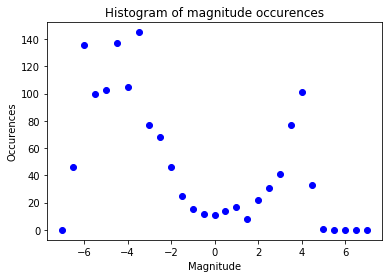

In [12]:
bigMagnitudes, bigOccurences = countMagnitudes (earthquakeMagnitudes)
print (bigOccurences)
plt.plot(bigMagnitudes, bigOccurences, "b o")
plt.title("Histogram of magnitude occurences")
plt.xlabel("Magnitude")
plt.ylabel("Occurences")

## Model With Varied Masses

In [93]:
def blockMotionVaryingMasses (t, blockPositions, vBlock, i, blockNum, kp, kc, mass, F0, v0, vf):
    """
    Returns the differential equation that models the motion of the blocks
    
    Arguments:  t - time
                blockPositions - the positions of the blocks
                vBlock - the velocity of the block
                i - the index of the current block
                blockNum - the number of blocks
                kp - spring constant of leaf springs
                kc - spring constant of springs between blocks
                mass - masses of individual blocks
                F0 - the static friction force
                v0 - initial velocity of top plate
                vf - the friction coefficient
                
    Returned: The differential equation modeling the motion of the individual blocks
    
    Examples:
    
    >>> blockMotion (0, (0, 1, 2, 3, 4), 0, 2, 5, 0, 0, 1, 0, 1, 20)
    array([ 0.,  0.])
    
    """
    # Sets position and velocity of the block
    xi = blockPositions[i] - i
    vi = vBlock
    mi = mass[i]
    
    # Block motion for the first block, connected to a block one distance unit away
    if i == 0:
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP - xi) + kp * (v0 * t - xi)
    
    # Block motion for the last block, connected to a block one distance unit away
    elif i == blockNum - 1:
        xiM = blockPositions[i - 1] - (i - 1)
        springForce = kc*(xiM - xi) + kp * (v0 * t - xi)
   
    # Block motion for all the middle blocks, connected to their neighbors
    else:
        xiM = blockPositions[i - 1] - (i - 1)
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi)
    
    frictionForce = friction (vi, vf, F0)
    
    # If spring force is large enough to overpower friction, change velocity
    if abs(springForce) <= abs(frictionForce):
        dv = -vi
        vi = 0
        dx = vi
    
    else: 
        totalForce = (springForce + frictionForce) / mi
        dx = vi
        dv = totalForce
        
    return np.array([dx, dv], float)

In [94]:
blockPositions = [] # Array to contain random block positions
blockMasses = [] # Array to contain random block masses
testBlockPositions = [] #Test array with set block positions
averageSpacing = 1 # Average spacing between blocks
kp = 40 # Leaf spring constant
kc = 250 # Spring constant between blocks
averageMass = 1 # Average mass of blocks
F0 = 50 # Static friction force
v0 = 0.01 # Velocity of the top plate
vBlock = 0 # Initial velocity of blocks
vf = 3.0 # Friction coefficient
blockNum = 25 # Number of blocks
maxTimeSteps = 50000 # Total number of timesteps to be calculated
minBLockV = 1e-8 # Velocity at which small timestep will kick in
timeStepShort = 0.005 # More presice timestep
timeStepLong = 1 # Less precice timestep
variation = 0.001 # Variation in distance between blocks

# Calculates inital block positions
for n in range(0, blockNum + 1):
    blockPositions.append(n * averageSpacing + (random.random() - 0.5) * 2 * variation)
    blockMasses.append(averageMass * (random.random() * 1.5 + 0.5))
    testBlockPositions.append(n)

In [95]:
# Calculates earthquake postition and velocity over the given time range
earthquake = eulerCoupledAdaptive (blockMotionVaryingMasses, 2, blockPositions, vBlock, blockNum, timeStepLong,\
                           timeStepShort, maxTimeSteps, minBLockV, kp, kc, blockMasses, F0, v0, vf) 

# Sets up new array for plotting
earthquakePlot = np.copy(earthquake)

In [110]:
earthquakeMoments = countQuakes(earthquakePlot, blockNum, timeStepShort)
earthquakeMagnitudes = list(map(np.log,earthquakeMoments))

C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0,0.5,'Occurences')

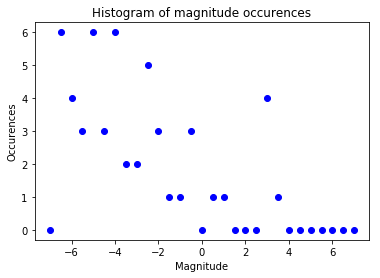

In [112]:
bigMagnitudes, bigOccurences = countMagnitudes (earthquakeMagnitudes)
print (bigOccurences)
plt.plot(bigMagnitudes, bigOccurences, "b o")
plt.title("Histogram of magnitude occurences")
plt.xlabel("Magnitude")
plt.ylabel("Occurences")

In [22]:
if __name__ == "__main__":
    import doctest
    doctest.testmod()